# 1. Prepare data

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size':20})

import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
#from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor

print(sys.version, sys.platform, sys.executable)

3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0] linux /mnt/d/spikeinterface/hussaini-to-nwb/venv/bin/python3


In [23]:
distantfile + suffix

'https://gin.g-node.org/NeuralEnsemble/ephy_testing_data/src/master/axona/axona_raw.set'

In [24]:
# This can be used to load the example data from gin (only 200ms long though!)

from urllib.request import urlopen

url_for_tests = r'https://gin.g-node.org/NeuralEnsemble/ephy_testing_data/src/master/axona'
localdir = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw'

distantfile = os.path.join(url_for_tests, base_filename)
localfile = os.path.join(localdir, base_filename)

for suffix in ['.bin', '.set']:
    dist = urlopen(distantfile + suffix)
    with open(localfile + suffix, 'wb') as f:
        f.write(dist.read())

In [25]:
# Use 20201004_Raw if you want to have more data (useful for spikesorting!)

import os

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'  #'axona_raw'
filename = os.path.join(dir_name, base_filename)

In [26]:
# Create axona recording extractor object

axo_cont = se.AxonaRecordingExtractor(filename=filename)

In [27]:
# Some general information about the recording

recording = axo_cont

print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(axo_cont.get_traces(
    start_frame=1000000, end_frame=1001000, channel_ids=2))))
print('Location of third electrode = {}'.format(recording.get_channel_property(channel_id=2, property_name='location')))

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000.0 Hz
Num. samples = 28800300
Stdev. on third channel = 6466.5625
Location of third electrode = [nan nan]


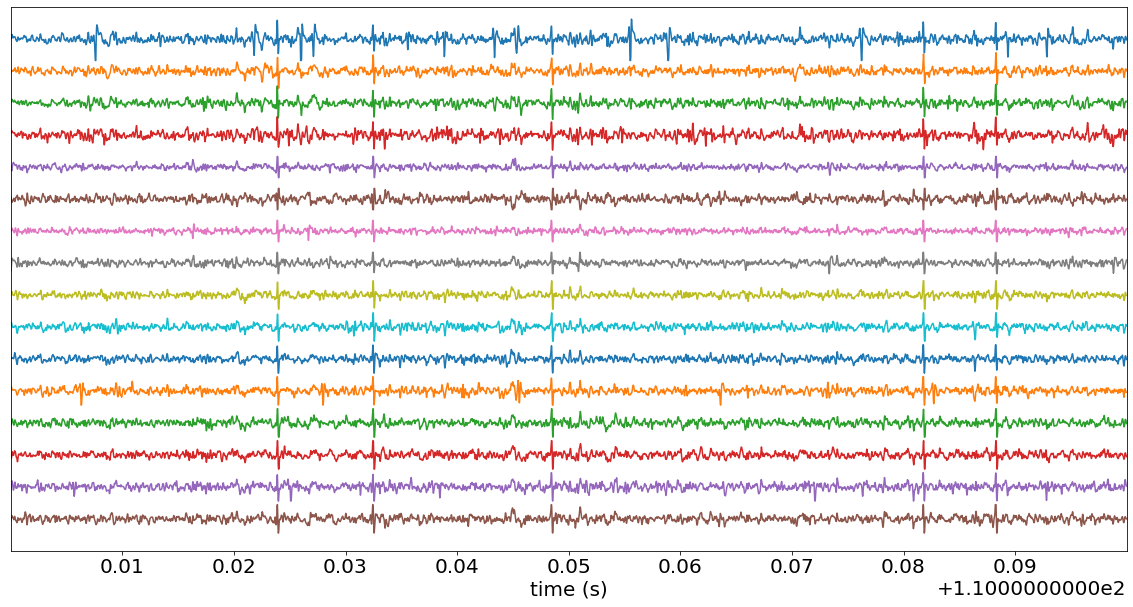

In [28]:
# Plot channels in time domain

w_ts = sw.plot_timeseries(recording, trange=[110, 110.1])

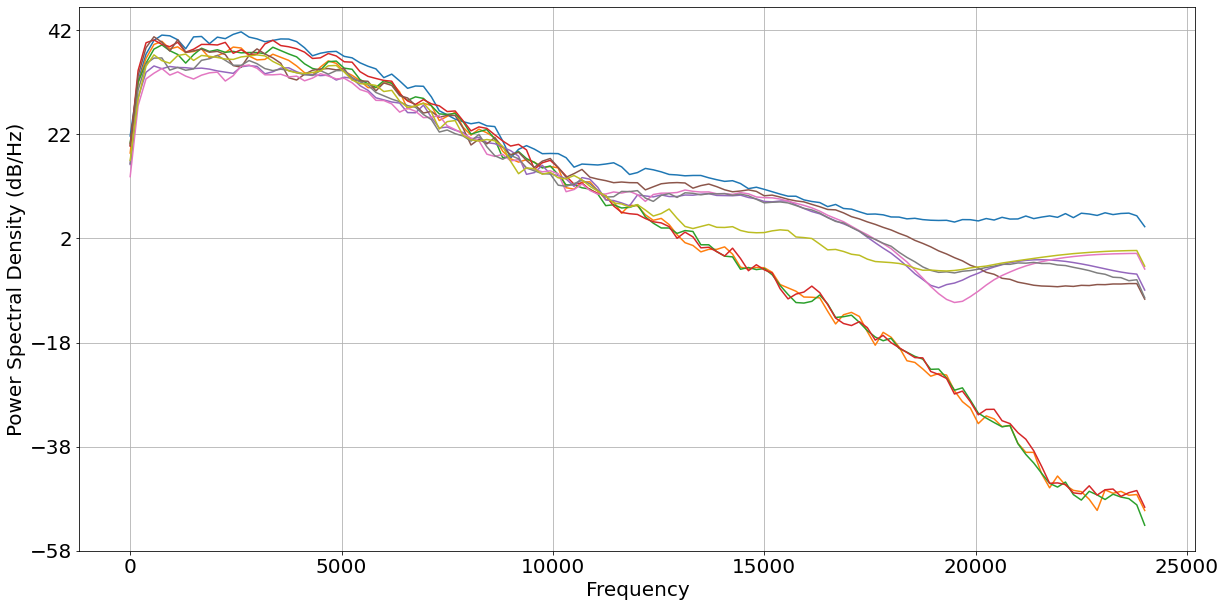

In [29]:
# Plot channels in frequency domain

w_sp = sw.plot_spectrum(recording, trange=[110, 110.1], channels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

In [30]:
# Do we already have channels groups (there should be 4 channels per tetrode)
# It does not seem that spikeextractors likes multiple streams from neo: 
# https://github.com/catalystneuro/spikeextractors/blob/axonaextractor/spikeextractors/extractors/neoextractors/neobaseextractor.py
# But maybe we can already assign groups in neo? Otherwise we can also do this in spikeextractors I suppose. 

print(f'Channel groups: {recording.get_channel_groups()}')

Channel groups: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [31]:
recording.set_channel_groups([i//4 for i in range(len(recording.get_channel_ids()))])

print(f'Channel groups: {recording.get_channel_groups()}')

Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


In [32]:
# Show electrode geometry
# --> Cannot do this without location information. Is there location information in the data?

#w_elec = sw.plot_electrode_geometry(recording)

In [33]:
print('Shared channel property names')
print(recording.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'name', 'offset']


# 2. Preprocessing

### Bandpass filter

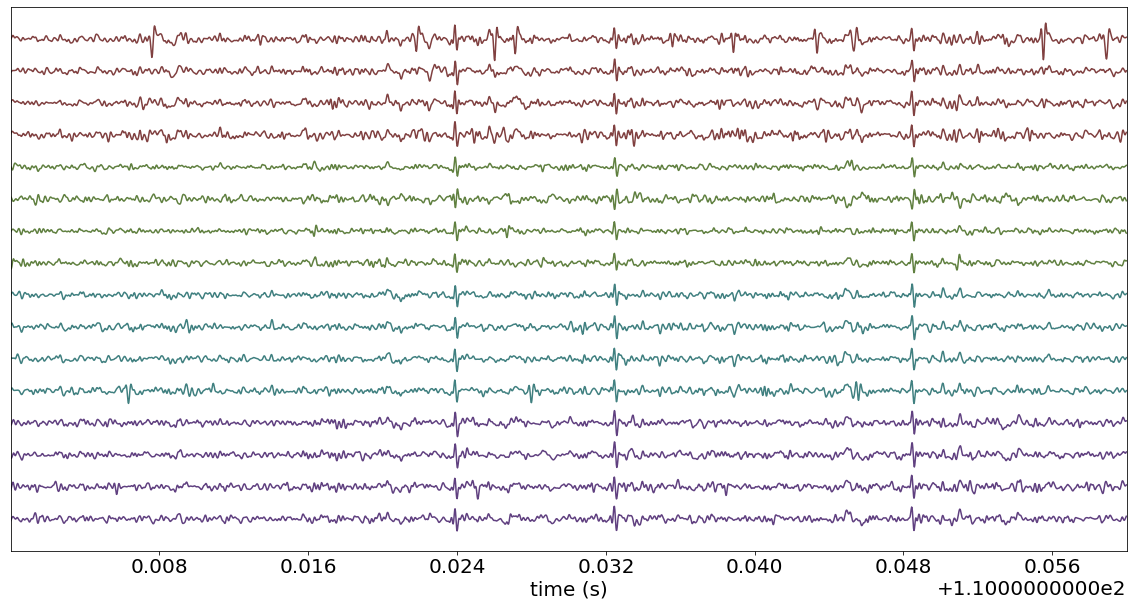

In [34]:
r_filt = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[110, 110.06], color_groups=True)

I do not see any reason to delete a channel for now, although all channels from the first tetrode, especially the first channel appear to be somewhat noisier than the rest.

### Common median reference (CMR)

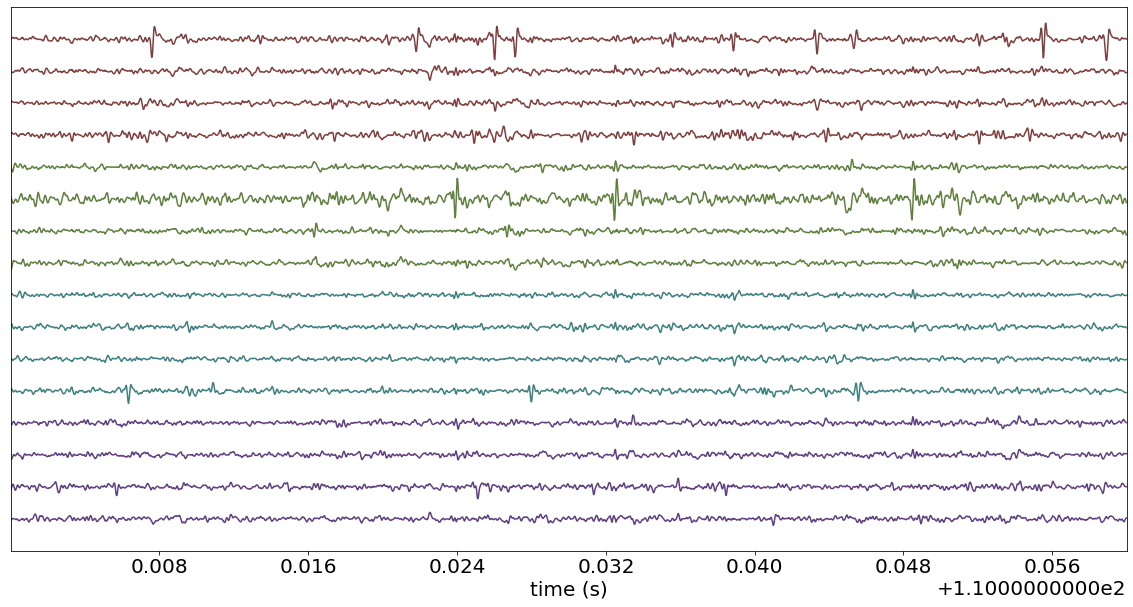

In [35]:
r_cmr = st.preprocessing.common_reference(r_filt, reference='median')

w = sw.plot_timeseries(r_cmr, trange=[110, 110.06], color_groups=True)

This doesn't change much, because as you can see in the data before rereferencing, the spikes are seen in all channels, so rereferencing to median is going to attentuate them all...

Hmm, for the second channel on the second tetrode the "common spikes" are actually inverted, making them even stronger after median referencing. What is going on?

In [36]:
# Select only subset of recording for speed's sake (20 seconds)

fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_cmr, start_frame=100*fs, end_frame=120*fs)

# 3. Cache data

In [37]:
# Create a binary file to cache data

perma_cache_filename = os.path.join(dir_name, 'cached_data_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path = perma_cache_filename)

In [38]:
print(r_cache.filename)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat


In [39]:
# Save corresponding extractor state to be able to read binary data after closing session

r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [40]:
# Load cached state to continue session

r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

# 4. Spike sorting

In [41]:
# Show installed spike sorting algorithms

ss.installed_sorters()

['klusta', 'mountainsort4']

In [42]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [43]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [44]:
ss.run_sorter?

In [45]:
ss.run_klusta?

In [46]:
# run spike sorting on entire recording

sorting_KL_all = ss.run_klusta(
    r_cache, 
    output_folder=os.path.join(dir_name, 'klusta_20s'), 
    adjacency_radius=50, 
    verbose=True
)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /mnt/d/spikeinterface/hussaini-to-nwb/../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/klusta_20s/run_klusta.sh
11:50:43 [I] creator:446          Using kwik file `/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/klusta_20s/recording.kwik`.

11:50:44 [I] launch:206           Starting spike detection.

11:50:44 [I] launch:53            SpikeDetekt parameters:

11:50:44 [I] launch:55            chunk_overlap_seconds = 0.015

11:50:44 [I] launch:55            chunk_size_seconds = 3

11:50:44 [I] launch:55            connected_component_join_size = 1

11:50:44 [I] launch:55            detect_spikes = negative

11:50:44 [I] launch:55            dtype = <f4

11:50:44 [I] launch:55            excerpt_size_seconds = 1

11:50:44 [I] launch:55       

11:51:37 [I] klustakwik Deleting cluster 4 (4 points): improves score by 866.0569670364494

11:51:37 [I] klustakwik Iteration 8F: 35 clusters, 199 changed, score=-789870.747339 (decreased by 359.324384)

11:51:37 [I] klustakwik Deleting cluster 28 (2 points): improves score by 578.8312085834332

11:51:37 [I] klustakwik Iteration 9F: 34 clusters, 169 changed, score=-790621.907763 (decreased by 751.160423)

11:51:37 [I] klustakwik Deleting cluster 17 (7 points): improves score by 923.0987674831413

11:51:37 [I] klustakwik Iteration 10F: 33 clusters, 210 changed, score=-791474.276002 (decreased by 852.368240)

11:51:38 [I] klustakwik Deleting cluster 3 (8 points): improves score by 502.16550633858424

11:51:38 [I] klustakwik Iteration 11F: 32 clusters, 116 changed, score=-792051.032820 (decreased by 576.756818)

11:51:38 [I] klustakwik Deleting cluster 12 (9 points): improves score by 453.6385457125725

11:51:38 [I] klustakwik Iteration 12F: 31 clusters, 91 changed, score=-792565.553739 (

In [47]:
# run spike sorting by group (=tetrode)

sorting_KL = ss.run_klusta(
    r_cache, 
    adjacency_radius=50, 
    output_folder=os.path.join(dir_name, 'klusta_20s_by_group'), 
    grouping_property='group', 
    parallel=True
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

Klusta found 26 units


Hm, interesting, sorting for each tetrode separately yielded more units.

In [48]:
print(f'Klusta unit ids: {sorting_KL.get_unit_ids()}')

Klusta unit ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [49]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [   893   3187   3192  13661  13713  15607  18510  18821  19062  19066
  19702  22317  22322  22326  22701  27020  27024  27029  28607  31862
  31866  43655  43658  45516  46166  46170  47583  47587  47596  48278
  49024  49029  49033  49086  49090  49321  50828  51410  51413  52441
  52693  53310  53646  54090  54817  55366  55597  55852  55857  55938
  56298  57049  57060  58346  59704  60715  60867  60970  60975  60982
  61978  63031  63035  67142  71067  72122  72126  73875  81243  82874
  82882  84512  84516  87577  87582  87586  87885  89428  89861  89864
  92164  92918  92971  92981  93015  93021  93162  93393  93728  93975
  93978  93982  93986  94895  94899  94904  95160  95164  95455  95459
  95463  96351  96355  96679  96742  96746  96751  97876  97881  97885
  97935  97940  98444  98447  98950  99276  99619  99623 100038 100246
 100250 100255 100388 101643 101651 101713 101718 102350 102354 102374
 103276 103280 103456 103461 103465 104286 104350 1047

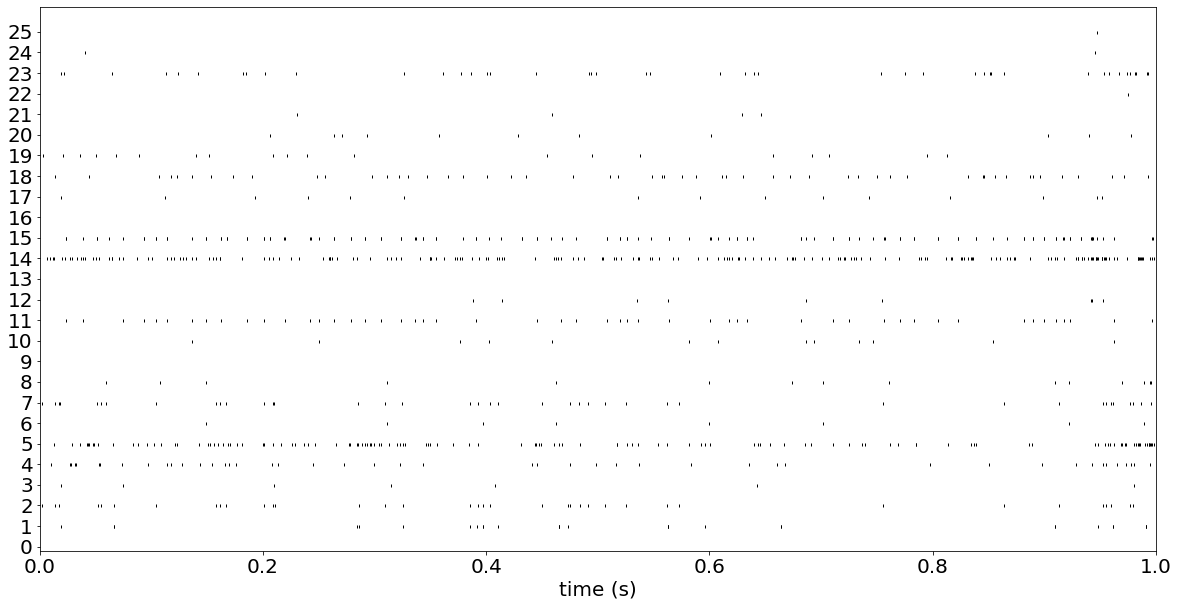

In [50]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0,1])

In [51]:
# Reloading spike sorting output (note that if sorting by group or property they need to be loaded in separately)

sorting_KL_grp = {}
for i in range(0, 4):
    sorting_KL_grp[i] = se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta_20s_by_group', str(i)))

In [52]:
sorting_KL_grp

{0: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7fe3bddd9d90>,
 1: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7fe3bddccd90>,
 2: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7fe3bdf6d2e0>,
 3: <spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor at 0x7fe3bde1de20>}

In [53]:
print(f'Klusta unit ids group 0: {sorting_KL_grp[0].get_unit_ids()}')

Klusta unit ids group 0: [0, 2, 3, 4, 5, 6, 7, 8, 9]


### Ironclust

In [58]:
# Set ironclust path (ironclust uses Matlab)

ss.IronClustSorter.set_ironclust_path('../specific_spikesorters/ironclust')
ss.IronClustSorter.ironclust_path

Setting IRONCLUST_PATH environment variable for subprocess calls to: /mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/ironclust


'/mnt/d/spikeinterface/hussaini-to-nwb/../specific_spikesorters/ironclust'

In [59]:
ss.installed_sorters()

['ironclust', 'klusta', 'mountainsort4']

In [ ]:
# run spike sorting by group
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Writing to binary .dat file: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


# 5. Postprocessing

The `postprocessing` submodule of `spiketoolkit` allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

In [54]:
# Extract waveforms

waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_KL, verbose=True)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  3.19it/s]


In [76]:
# Only up to 300 waveforms are extracted by default

waveforms[1].shape

(300, 16, 288)

In [79]:
# But in total the second unit has 464

len(sorting_KL.get_unit_spike_train(1))

464

In [80]:
sorting_KL.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [81]:
print(sorting_KL.get_unit_spike_features(0, 'waveforms_idxs'))

[0 1 2 3 4 5]
